In [1]:
!pip install -U scikit-learn

     |████████████████████████████████| 10.9MB 5.1MB/s eta 0:00:01
  Found existing installation: scikit-learn 0.21.2
    Uninstalling scikit-learn-0.21.2:
      Successfully uninstalled scikit-learn-0.21.2


In [2]:
# Having all the necessary libaries for 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_style('whitegrid')
import warnings
import gc
from sklearn import preprocessing,metrics 
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn import linear_model,svm
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_confusion_matrix


# Pandas options
# pd.set_option('display.max_colwidth', 1000, 'display.max_rows', None, 'display.max_columns', None)

# Plotting options
%matplotlib inline
# mpl.style.use('ggplot')
# sns.set(style='whitegrid')

# 1. Importing the Data

Read the data into a pandas dataframe

In [3]:
# Define a variable that points to the folder where data is stored
path = '/Users/lunahuang/Desktop/Machine_Learning/Loan_Shark/Data'

In [4]:
start_df = pd.read_csv(f'{path}/loan.csv')

/Users/lunahuang/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
!ls "/content/gdrive/My Drive/Colab Notebooks/Loan Shark/Data/loan.csv"

'/content/gdrive/My Drive/Colab Notebooks/Loan Shark/Data/loan.csv'


In [0]:
start_df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Loan Shark/Data/loan.csv', low_memory=False)

Check the basic dataframe info

In [5]:
df = start_df.copy(deep=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260668 entries, 0 to 2260667
Columns: 145 entries, id to settlement_term
dtypes: float64(105), int64(4), object(36)
memory usage: 2.4+ GB


There are 2.2 million rows and 145 columns. The data set is about 2.4GB.

Let's take a look at the first 5 rows to see what we are getting into.

In [6]:
df.head(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,4000,4000,4000.0,36 months,18.94,146.51,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,30000,30000,30000.0,60 months,16.14,731.78,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


We also want to understand the columns we have with the data dictionary provided.

# 2. Target Variable

We are going to predict the variable loan_status. What are the value counts?

In [7]:
df['loan_status'].value_counts(dropna=False)

Fully Paid                                             1041952
Current                                                 919695
Charged Off                                             261655
Late (31-120 days)                                       21897
In Grace Period                                           8952
Late (16-30 days)                                         3737
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     31
Name: loan_status, dtype: int64

We are going to only considers the Charged Off and Fully Paid values.

In [8]:
df = df.loc[df['loan_status'].isin(['Fully Paid','Charged Off'])]

In [9]:
df.shape

(1303607, 145)

There are still 1303607 loans remaining. Lets recheck their status.

In [10]:
di = {"Fully Paid":0, "Charged Off":1}   #converting target variable to boolean
df= df.replace({"loan_status": di})

In [11]:
df['loan_status'].value_counts(normalize=True)

0    0.799284
1    0.200716
Name: loan_status, dtype: float64

About 80% of the loans are fully paid and the rest 20% percent are charged off, so we can see a somewhat imbalance in our target variable

# 3. Feature space limiting

The dataset consists of 145 features for each loan. We will divide our feature selection in two steps:

- Drop the features with more than 30% missing data.
-  Of the remaining features, we chose only those that would be the best ones.

## 3.1 Drop features with missing data

First calculate the percentage of missing data for each feature:

In [12]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

In [13]:
# Missing values statistics
miss_values = missing_values_table(df)
miss_values.head(10)

Your selected dataframe has 145 columns.
There are 105 columns that have missing values.


,Missing Values,% of Total Values
id,1303607,100.0
url,1303607,100.0
member_id,1303607,100.0
next_pymnt_d,1303607,100.0
orig_projected_additional_accrued_interest,1300174,99.7
hardship_type,1298272,99.6
hardship_reason,1298272,99.6
hardship_status,1298272,99.6
hardship_last_payment_amount,1298272,99.6
hardship_payoff_balance_amount,1298272,99.6


In [14]:
missing_fractions = df.isnull().mean().sort_values(ascending=False)

Let's visualize the distribution of missing data

Text(0, 0.5, 'Feature count')

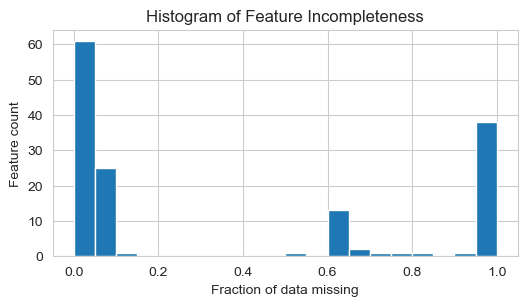

In [15]:
plt.figure(figsize=(6,3),dpi=100)
missing_fractions.plot.hist(bins=20)
plt.title('Histogram of Feature Incompleteness')
plt.xlabel('Fraction of data missing')
plt.ylabel('Feature count')

We can see that there a huge gap between the features missing some data(<20%) and those who are missing a lot of data(>40%). Since its very difficult to impute the remaining data accurately for the columns with more than 30% missing values, we drop those columns.

First storing all columns missing more than 30% data into a list:

In [16]:
drop_list = list(missing_fractions[missing_fractions>0.3].index)
print(drop_list)

['id', 'member_id', 'url', 'next_pymnt_d', 'orig_projected_additional_accrued_interest', 'hardship_length', 'hardship_type', 'hardship_reason', 'hardship_status', 'deferral_term', 'hardship_amount', 'hardship_end_date', 'payment_plan_start_date', 'hardship_start_date', 'hardship_dpd', 'hardship_last_payment_amount', 'hardship_loan_status', 'hardship_payoff_balance_amount', 'sec_app_mths_since_last_major_derog', 'sec_app_revol_util', 'revol_bal_joint', 'sec_app_collections_12_mths_ex_med', 'sec_app_chargeoff_within_12_mths', 'sec_app_num_rev_accts', 'sec_app_open_act_il', 'sec_app_open_acc', 'sec_app_mort_acc', 'sec_app_inq_last_6mths', 'sec_app_earliest_cr_line', 'verification_status_joint', 'dti_joint', 'annual_inc_joint', 'settlement_percentage', 'settlement_term', 'settlement_status', 'settlement_amount', 'settlement_date', 'debt_settlement_flag_date', 'desc', 'mths_since_last_record', 'mths_since_recent_bc_dlq', 'mths_since_last_major_derog', 'il_util', 'mths_since_recent_revol_del

No of features being dropped

In [17]:
len(drop_list)

58

Dropping these features:

In [18]:
df.drop(labels=drop_list, axis=1, inplace=True)

In [19]:
df.shape

(1303607, 87)

## 3.2 Keeping useful features

After researching through the data dictionary we decide to keep only the use full features from all the remaining features we have.

In [20]:
features = ['annual_inc', 'grade', 'emp_length', 'funded_amnt', 
                'avg_cur_bal', 'last_pymnt_amnt', 'open_acc', 'bc_util', 'mort_acc', 'pub_rec', 
                'debt_settlement_flag', 'term', 'installment', 'int_rate', 'delinq_2yrs', 'home_ownership', 
                'acc_now_delinq', 'loan_amnt', 'total_pymnt', 'loan_status'] 
Final_data = df[features]
Final_data = Final_data.reset_index(drop=True)
Final_data.shape

(1303607, 20)

In [21]:
Final_data['emp_length'].value_counts()

10+ years    428547
2 years      117820
< 1 year     104550
3 years      104200
1 year        85677
5 years       81623
4 years       78029
6 years       60933
8 years       59125
7 years       58145
9 years       49504
Name: emp_length, dtype: int64

In [22]:
Final_data.head()

,annual_inc,grade,emp_length,funded_amnt,avg_cur_bal,last_pymnt_amnt,open_acc,bc_util,mort_acc,pub_rec,debt_settlement_flag,term,installment,int_rate,delinq_2yrs,home_ownership,acc_now_delinq,loan_amnt,total_pymnt,loan_status
0,100000.0,D,5 years,30000,42939.0,30082.32,11.0,46.9,1.0,1.0,N,36 months,1151.16,22.35,0.0,MORTGAGE,0.0,30000,30026.442500,0
1,45000.0,C,< 1 year,40000,15059.0,40910.48,18.0,67.3,1.0,0.0,N,60 months,975.71,16.14,0.0,MORTGAGE,0.0,40000,40856.678960,0
2,100000.0,A,10+ years,20000,57309.0,20228.39,9.0,29.9,5.0,0.0,N,36 months,622.68,7.56,0.0,MORTGAGE,0.0,20000,20215.792430,0
3,38500.0,B,10+ years,4500,2428.0,4553.46,12.0,28.9,0.0,0.0,N,36 months,147.99,11.31,0.0,RENT,0.0,4500,4549.217149,0
4,450000.0,E,3 years,8425,34516.0,8754.30,21.0,74.6,4.0,0.0,N,36 months,345.18,27.27,0.0,MORTGAGE,0.0,8425,8735.148975,0


# 4. Data Transformation

We need to transform some categotial values in our dataset to numerical labels so we can use it to work with some models
Grade and home_ownership should be encoded to numerical values.
Also emp_length is in a format of string i.e. "5 years","1 year" which needs to be changed to its numerical values.

In [23]:
Final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303607 entries, 0 to 1303606
Data columns (total 20 columns):
annual_inc              1303607 non-null float64
grade                   1303607 non-null object
emp_length              1228153 non-null object
funded_amnt             1303607 non-null int64
avg_cur_bal             1236059 non-null float64
last_pymnt_amnt         1303607 non-null float64
open_acc                1303607 non-null float64
bc_util                 1242221 non-null float64
mort_acc                1256326 non-null float64
pub_rec                 1303607 non-null float64
debt_settlement_flag    1303607 non-null object
term                    1303607 non-null object
installment             1303607 non-null float64
int_rate                1303607 non-null float64
delinq_2yrs             1303607 non-null float64
home_ownership          1303607 non-null object
acc_now_delinq          1303607 non-null float64
loan_amnt               1303607 non-null int64
total_pymnt   

In [24]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
Final_data["home_ownership"] = lb_make.fit_transform(Final_data["home_ownership"])
Final_data["grade"] = lb_make.fit_transform(Final_data["grade"])
Final_data["debt_settlement_flag"] = lb_make.fit_transform(Final_data["debt_settlement_flag"])
Final_data["term"] = lb_make.fit_transform(Final_data["term"])
Final_data.drop('emp_length',axis=1, inplace=True)
print("Current shape of dataset :",Final_data.shape)
Final_data.head()

Current shape of dataset : (1303607, 19)


,annual_inc,grade,funded_amnt,avg_cur_bal,last_pymnt_amnt,open_acc,bc_util,mort_acc,pub_rec,debt_settlement_flag,term,installment,int_rate,delinq_2yrs,home_ownership,acc_now_delinq,loan_amnt,total_pymnt,loan_status
0,100000.0,3,30000,42939.0,30082.32,11.0,46.9,1.0,1.0,0,0,1151.16,22.35,0.0,1,0.0,30000,30026.442500,0
1,45000.0,2,40000,15059.0,40910.48,18.0,67.3,1.0,0.0,0,1,975.71,16.14,0.0,1,0.0,40000,40856.678960,0
2,100000.0,0,20000,57309.0,20228.39,9.0,29.9,5.0,0.0,0,0,622.68,7.56,0.0,1,0.0,20000,20215.792430,0
3,38500.0,1,4500,2428.0,4553.46,12.0,28.9,0.0,0.0,0,0,147.99,11.31,0.0,5,0.0,4500,4549.217149,0
4,450000.0,4,8425,34516.0,8754.30,21.0,74.6,4.0,0.0,0,0,345.18,27.27,0.0,1,0.0,8425,8735.148975,0


In [25]:
Final_data.isnull().sum()

annual_inc                  0
grade                       0
funded_amnt                 0
avg_cur_bal             67548
last_pymnt_amnt             0
open_acc                    0
bc_util                 61386
mort_acc                47281
pub_rec                     0
debt_settlement_flag        0
term                        0
installment                 0
int_rate                    0
delinq_2yrs                 0
home_ownership              0
acc_now_delinq              0
loan_amnt                   0
total_pymnt                 0
loan_status                 0
dtype: int64

In [26]:
Final_data.fillna(Final_data.mean(),inplace=True)

In [27]:
Final_data.isnull().sum()

annual_inc              0
grade                   0
funded_amnt             0
avg_cur_bal             0
last_pymnt_amnt         0
open_acc                0
bc_util                 0
mort_acc                0
pub_rec                 0
debt_settlement_flag    0
term                    0
installment             0
int_rate                0
delinq_2yrs             0
home_ownership          0
acc_now_delinq          0
loan_amnt               0
total_pymnt             0
loan_status             0
dtype: int64

In [28]:
scl = preprocessing.StandardScaler()
fields = Final_data.columns.values[:-1]
data_clean_full = pd.DataFrame(scl.fit_transform(Final_data[fields]), columns = fields)
data_clean_full['loan_status'] = Final_data['loan_status']
data_clean_full['loan_status'].value_counts()


0    1041952
1     261655
Name: loan_status, dtype: int64

In [29]:
loanstatus_0 = data_clean_full[data_clean_full["loan_status"]==0]
loanstatus_1 = data_clean_full[data_clean_full["loan_status"]==1]
subset_of_loanstatus_0 = loanstatus_0.sample(n=25000)
subset_of_loanstatus_1 = loanstatus_1.sample(n=25000)
data_clean = pd.concat([subset_of_loanstatus_1, subset_of_loanstatus_0])
data_clean = data_clean.sample(frac=1).reset_index(drop=True)
print("Current shape of dataset :",data_clean.shape)

# data_clean.drop('emp_length',axis=1, inplace=True)
data_clean.head(5)

Current shape of dataset : (50000, 19)


,annual_inc,grade,funded_amnt,avg_cur_bal,last_pymnt_amnt,open_acc,bc_util,mort_acc,pub_rec,debt_settlement_flag,term,installment,int_rate,delinq_2yrs,home_ownership,acc_now_delinq,loan_amnt,total_pymnt,loan_status
0,-0.273509,-0.579430,-1.024455,-1.194475e-01,-0.005669,0.806484,5.592825e-01,1.641595e-01,-0.357498,-0.158607,-0.564300,-0.990814,-0.526667,-0.362051,-0.997298,-0.065476,-1.024974,-0.889915,0
1,-0.276550,2.504753,0.691956,2.224266e+00,-0.744902,-0.840275,1.425647e+00,6.721972e-01,-0.357498,-0.158607,1.772108,0.527057,2.044469,-0.362051,-0.997298,-0.065476,0.690634,0.925859,1
2,-0.690689,-1.350475,0.068068,1.147376e-16,0.528678,-0.108382,9.452773e-14,-1.128070e-16,1.301257,-0.158607,-0.564300,0.119799,-1.125339,-0.362051,0.568545,-0.065476,0.067037,0.143992,0
3,0.268969,-0.579430,-0.046935,-7.484579e-01,-0.704106,0.440538,8.710289e-01,-8.519159e-01,-0.357498,6.304897,-0.564300,0.012085,-1.022409,1.917778,-0.997298,-0.065476,-0.047911,-0.851342,1
4,-0.016545,0.962661,1.755728,9.752023e-01,-0.658107,-1.023248,5.411577e-01,-3.438782e-01,-0.357498,-0.158607,1.772108,1.269981,1.204228,-0.362051,-0.997298,-0.065476,1.753908,-0.472633,1


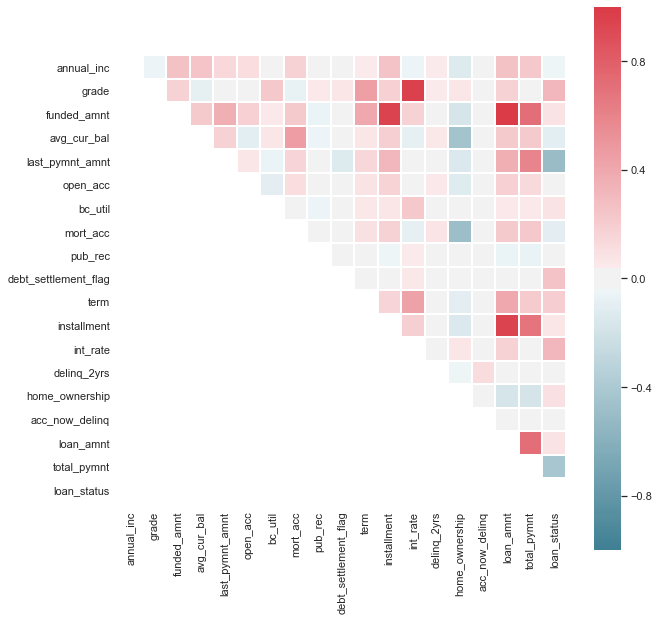

In [30]:
dataViz = data_clean
sns.set_context(context='notebook')
fig, ax = plt.subplots(figsize=(10,10)) 
corr = dataViz.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.tril_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, cmap=cmap,linewidths=1, vmin=-1, vmax=1, square=True, cbar=True, center=0, ax=ax, mask=mask)

### ROC Plot function

Creating a ROC function to be used for all the models.

In [31]:
sns.set('talk', 'whitegrid', 'dark', font_scale=1, font='Ricty',rc={"lines.linewidth": 2, 'grid.linestyle': '--'})
def plotAUC(truth, pred, lab):
    fpr, tpr, _ = metrics.roc_curve(truth,pred)
    roc_auc = metrics.auc(fpr, tpr)
    lw = 2
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    plt.plot(fpr, tpr, color= c,lw=lw, label= lab +'(AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve') #Receiver Operating Characteristic 
    plt.legend(loc="lower right")

### Confusion Matrix function

Creating a Confusion Matrix function to be used for all the models.

In [32]:
X_train, X_test, y_train, y_test = train_test_split(data_clean_full.iloc[:,:-1],
                                                    data_clean_full.iloc[:,-1], test_size=0.2,
                                                    random_state=42)
bs_train, bs_test = train_test_split(data_clean_full, test_size = 0.2,
                                     random_state=42) #just for bootstrapping

In [33]:
X_train.head()

,annual_inc,grade,funded_amnt,avg_cur_bal,last_pymnt_amnt,open_acc,bc_util,mort_acc,pub_rec,debt_settlement_flag,term,installment,int_rate,delinq_2yrs,home_ownership,acc_now_delinq,loan_amnt,total_pymnt
370638,0.625863,0.191616,0.919086,1.117442,-0.660810,0.623511,1.418398,2.196310,-0.357498,-0.158607,-0.564300,1.196052,-0.140157,0.777864,-0.997298,-0.065476,0.917657,-0.592436
834646,-0.230682,1.733707,1.376220,-0.556260,2.414324,0.257565,1.414773,-0.851916,1.301257,-0.158607,1.772108,1.193256,2.130593,-0.362051,0.568545,-0.065476,1.374578,1.927309
128350,-0.758884,0.191616,-0.705324,-0.668728,-0.058527,-1.206221,1.215400,-0.851916,-0.357498,-0.158607,-0.564300,-0.574440,0.431207,-0.362051,-0.997298,-0.065476,-0.705992,-0.500133
1169890,-0.329370,0.962661,0.022067,1.486131,0.698485,-0.474328,-0.477455,-0.343878,-0.357498,-0.158607,1.772108,-0.270988,0.905943,-0.362051,-0.997298,-0.065476,0.021058,0.433674
1074160,-0.087924,-0.579430,0.068068,-0.587673,0.793341,3.917029,0.102538,0.164160,-0.357498,-0.158607,-0.564300,0.221307,-0.333412,-0.362051,1.090493,-0.065476,0.067037,0.173751


In [34]:
data_clean.isnull().sum()

annual_inc              0
grade                   0
funded_amnt             0
avg_cur_bal             0
last_pymnt_amnt         0
open_acc                0
bc_util                 0
mort_acc                0
pub_rec                 0
debt_settlement_flag    0
term                    0
installment             0
int_rate                0
delinq_2yrs             0
home_ownership          0
acc_now_delinq          0
loan_amnt               0
total_pymnt             0
loan_status             0
dtype: int64

In [35]:
print(X_train.shape)
print(X_test.shape)

(1042885, 18)
(260722, 18)


## 6. Models

### 6.1 Random Forest with randomized search



In [0]:
from sklearn.model_selection import RandomizedSearchCV
rf = RandomForestClassifier(criterion='gini', random_state=0)
maxFeatures = range(1,data_clean.shape[1]-1)
param_dist = dict(max_features=maxFeatures)
rand = RandomizedSearchCV(rf, param_dist, cv=10, scoring='accuracy', n_iter=len(maxFeatures), random_state=10)
X=data_clean.iloc[:,:-1].values
y=data_clean.iloc[:,-1].values
rand.fit(X,y)
# mean_scores = [result.mean_validation_score for result in rand.grid_scores_]
#print('Best Accuracy = '+str(rand.best_score_))
print(rand.best_estimator_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=9,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


In [0]:
randomForest = RandomForestClassifier(bootstrap=True,criterion = "gini",max_features=rand.best_estimator_.max_features,random_state=0,n_jobs=-1 )
rfModel = randomForest.fit(X_train,y_train)
rfPredict = randomForest.predict(X_test)
rfPredictproba = randomForest.predict_proba(X_test)[:,1] #for ROC curve
rfAccuracy = accuracy_score(y_test,rfPredict)
roc_score = metrics.roc_auc_score(y_test,rfPredict)
print(rfAccuracy)

0.9953436994193049


### Feature Evaluation

Text(0, 0.5, 'Normalized Gini Importance')

findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans.


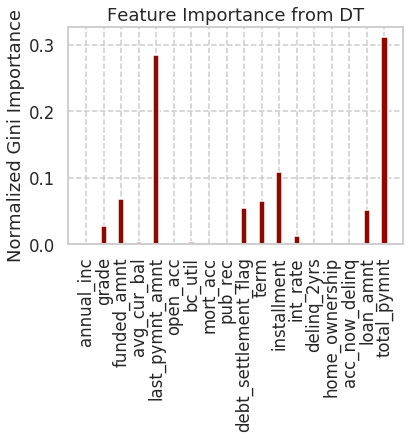

In [0]:
fig, ax = plt.subplots()
width=0.35
ax.bar(np.arange(len(features)-2), randomForest.feature_importances_, width, color='r')
ax.set_xticks(np.arange(len(randomForest.feature_importances_)))
ax.set_xticklabels(X_train.columns.values,rotation=90)
plt.title('Feature Importance from DT')
ax.set_ylabel('Normalized Gini Importance')

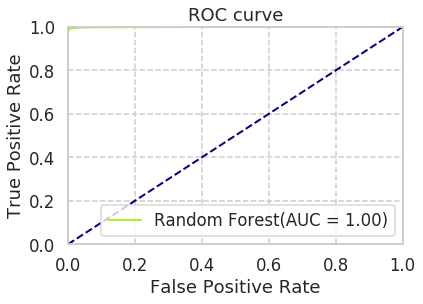

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

In [0]:
plotAUC(y_test,rfPredictproba, 'Random Forest')
plt.show()
plt.figure(figsize=(6,6))

Confusion matrix, without normalization
[[207823    278]
 [   936  51685]]
Normalized confusion matrix
[[0.99866411 0.00133589]
 [0.01778758 0.98221242]]


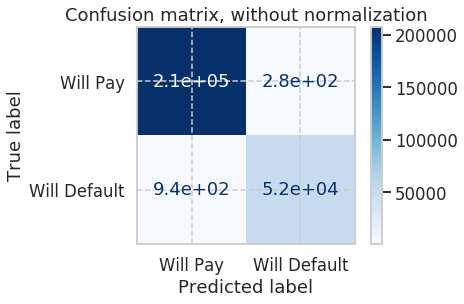

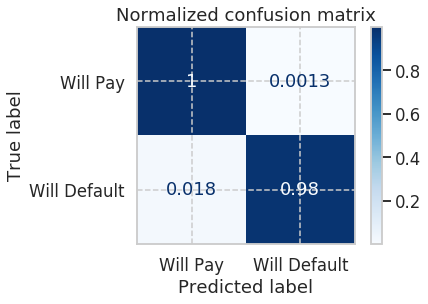

In [0]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
class_names =["Will Pay", "Will Default"]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(rfModel, X_test, y_test,
                                  display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

### 6.2 k-NN Model

#### a) Tune Hyperparameter

In [36]:
a_train = 1042885*0.005
b_train = 260722*0.005
print("a = ", a_train)
print("b = ", b_train)

a =  5214.425
b =  1303.6100000000001


In [37]:
knn_X_train = X_train.copy()
knn_X_test = X_test.copy()
knn_y_train = y_train.copy()
knn_y_test = y_test.copy()

In [38]:
# a smaller data set for hyperparameter tuning
knn_X_train_s = X_train.sample(n=5214, random_state=1)
knn_X_test_s = X_test.sample(n=1303, random_state=1)
knn_y_train_s = y_train.sample(n=5214, random_state=1)
knn_y_test_s = y_test.sample(n=1303, random_state=1)

print(knn_X_train_s.shape, knn_X_test_s.shape, 
      knn_y_train_s.shape, knn_y_test_s.shape)

(5214, 18) (1303, 18) (5214,) (1303,)


findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans.


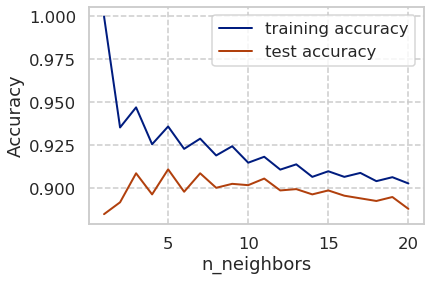

In [39]:
# Hyperparameter tuning
# Determining the optimal value of k for k-NN on the loan dataset

num_neighs = []
knn_training_accuracy_s = [] 
knn_test_accuracy_s = []
difference = []

# try n_neighbors from 1 to 20 
neighbors_settings = range(1, 21)

for n_neighbors in neighbors_settings:
  # build the model
  knn_model = KNeighborsClassifier(n_neighbors=n_neighbors) 
  knn_model.fit(knn_X_train_s, knn_y_train_s)
  # record n_neighbors
  num_neighs.append(n_neighbors)
  # record training set accuracy 
  knn_training_accuracy_s.append(knn_model.score(knn_X_train_s, knn_y_train_s)) 
  # record testing set accuracy 
  knn_test_accuracy_s.append(knn_model.score(knn_X_test_s, knn_y_test_s))
  # calculate the  difference
  d = knn_model.score(knn_X_train_s, knn_y_train_s) - knn_model.score(knn_X_test_s, knn_y_test_s)
  difference.append(d)

plt.plot(neighbors_settings, knn_training_accuracy_s, label="training accuracy") 
plt.plot(neighbors_settings, knn_test_accuracy_s, label="test accuracy") 
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

In [40]:
'''Print it out as a table'''
knn_accuracy_df =  pd.DataFrame({"Num of neighbors": num_neighs,
                             "Training set accuracy Score": knn_training_accuracy_s, 
                             "Testing set accuracy Score": knn_test_accuracy_s,
                             "Difference ": difference})  #"Testingt set accuracy Score": knn_test_accuracy,
knn_accuracy_df


,Num of neighbors,Training set accuracy Score,Testing set accuracy Score,Difference
0,1,1.000000,0.884881,0.115119
1,2,0.935366,0.891788,0.043578
2,3,0.947066,0.908672,0.038393
3,4,0.925585,0.896393,0.029192
4,5,0.935942,0.910975,0.024967
5,6,0.922900,0.897928,0.024972
6,7,0.928845,0.908672,0.020173
7,8,0.919064,0.900230,0.018834
8,9,0.924434,0.902533,0.021902
9,10,0.914845,0.901765,0.013079


No handles with labels found to put in legend.


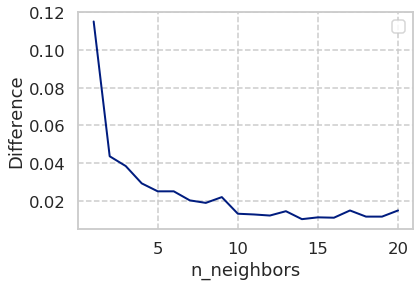

In [41]:
plt.plot(neighbors_settings, difference)
plt.ylabel("Difference")
plt.xlabel("n_neighbors")
plt.legend()

k = 14 seems to be the best performance. We will use this value to train our final model.



#### b) Creating Final Model

In [42]:
# Create new k-NN model with the k=10 on training dataset
final_knn_model = KNeighborsClassifier(n_neighbors = 14,weights = 'uniform')

In [43]:
# Fit the model with training set
final_knn_model.fit(knn_X_train,knn_y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=14, p=2,
                     weights='uniform')

#### c) Predict on the test set

In [44]:
knn_final_y_pred = final_knn_model.predict(knn_X_test)
print("Test set predictions: ", knn_final_y_pred)

Test set predictions:  [0 1 0 ... 1 0 0]


#### d) Evaluting the k-NN Model

In [45]:
# Elvaluate k-NN model
print("Test set accuracy: {:.2f}".format(final_knn_model.score(knn_X_test, knn_y_test)))

Test set accuracy: 0.95


Our k-NN model is about 95% accurate, meaning the model predicted the correctly for 95% of the samples in the test dataset.

In [47]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve,roc_auc_score

In [48]:
# Confusion Matrix

knn_c_mat = confusion_matrix(knn_y_test,knn_final_y_pred)
knn_c_mat_df = pd.DataFrame(knn_c_mat)
knn_c_mat_df.head(2)

knn_c_mat_df.columns = ["Bad Loan","Good Loan"]
knn_c_mat_df.index = ["Bad Loan","Good Loan"]
knn_c_mat_df = knn_c_mat_df.T
knn_c_mat_df

,Bad Loan,Good Loan
Bad Loan,207513,12567
Good Loan,588,40054


Text(40.49999999999999, 0.5, 'Predicted')

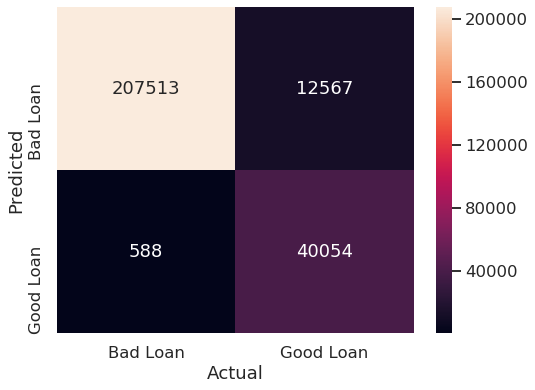

In [49]:
# Make a heatmap of the confusion matrix with seaborn

plt.figure(figsize = (8,6))
sns.heatmap(knn_c_mat_df,annot = True,fmt = 'g')
plt.xlabel("Actual")
plt.ylabel("Predicted")

In [50]:
# Caculate Precision, Recall(Sensitivity) and F1 score

knn_scores = classification_report(knn_y_test,knn_final_y_pred)
print(knn_scores)

              precision    recall  f1-score   support

           0       0.94      1.00      0.97    208101
           1       0.99      0.76      0.86     52621

    accuracy                           0.95    260722
   macro avg       0.96      0.88      0.91    260722
weighted avg       0.95      0.95      0.95    260722



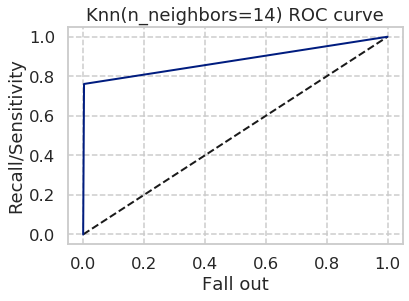

In [61]:
# Receiver Operating Characteristic (ROC) and Area Under the Curve (AUC)

knn_rec, knn_fall_out, knn_thresholds = roc_curve(knn_y_test,knn_final_y_pred)

plt.plot([0,1],[0,1],'k--')
plt.plot(knn_rec,knn_fall_out, label='Knn')
plt.xlabel('Fall out')
plt.ylabel('Recall/Sensitivity')
plt.title('Knn(n_neighbors=14) ROC curve')
plt.show()

In [52]:
#Area under ROC curve
roc_auc_score(knn_y_test, knn_final_y_pred)

0.8791767229619284

The AUC score is 0.879 means most of positive points have a higher score than negative points and the model obtain great predictions.